# Effortless Neural Style Transfer with TFHub
> Quickly apply Style Transfer to stuyle images using pretrained models from Tensorflow Hub

- toc: true
- badges: true
- comments: true
- author: dzlab
- categories: [tensorflow, artistic, generative]

Neural style transfer was first introduced in [Leon A. Gatys’ paper, A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576). It's a very interesting use of Deep Learning to generate artistic images by mixing three images: a content image, a style reference image (e.g. some famous painter's artwork), and an input image that will be styled. The output result is an image that looks like the input image but but “painted” in the same style as the style image.


Implementing Neural Style Transfer from scratch can be challenging (see this tutorial for a Tensorflow implementation - [link](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398)), but likely we can leverage TensorFlow Hub (TFHub) and use a pretrained implementation of Neural Style Transfer to style our own images. 

![Image of Green Sea Turtle by P. Lindgren, from Wikimedia Commons](https://miro.medium.com/max/1248/0*h5YONGux0M4j1Bdf)

In this article, we will use a Neural Style Transfer module from TensorFlow Hub [link](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) that performs fast artistic style transfer and can work with arbitrary painting styles.

First, let's import the needed dependencies:

In [29]:
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow_hub import load

Then, we need to define a function to load images into a TensorFlow tensor and do some processing (e.g. rescaling)

In [14]:
def load_image(image_path):
    dimension = 512
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    longest_dimension = max(shape)
    scale = dimension / longest_dimension
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)
    return image

Because, the output of the model is a tensor, we need to define a helper function to convert such tensor into a NumPy array so that we can display the image with `matplotlib`

In [3]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return tensor

To easily display all the images at once, we define the following helper function

In [41]:
def show_images(images, num_rows, num_cols, figsize=(35, 15)):
    figure, axis = plt.subplots(num_rows, num_cols, figsize=figsize)
    for index, image in enumerate(images):
        row, col = int(index / num_cols), index % num_cols
        if num_rows == 1:
            axis[col].imshow(image)
            axis[col].axis('off')
        else:
            axis[row, col].imshow(image)
            axis[row, col].axis('off')

Let's download the Style Transfer module from Tensorflow Hub and load it

In [5]:
module_url = ('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
hub_module = load(module_url)

Get some images for testing


In [11]:
%%bash
rm -rf images
mkdir -p images
curl -s -o images/bicycle1.jpg https://cdn.pixabay.com/photo/2016/11/22/23/49/cyclists-1851269_960_720.jpg
curl -s -o images/animal1.jpg https://cdn.pixabay.com/photo/2014/05/20/21/20/bird-349026_960_720.jpg
curl -s -o images/car2.jpg https://cdn.pixabay.com/photo/2016/09/11/10/02/renault-juvaquatre-1661009_960_720.jpg

Load the content images and display them

In [15]:
images = []
image_paths = glob.glob('images/*')
for path in image_paths:
    images.append(load_image(path))

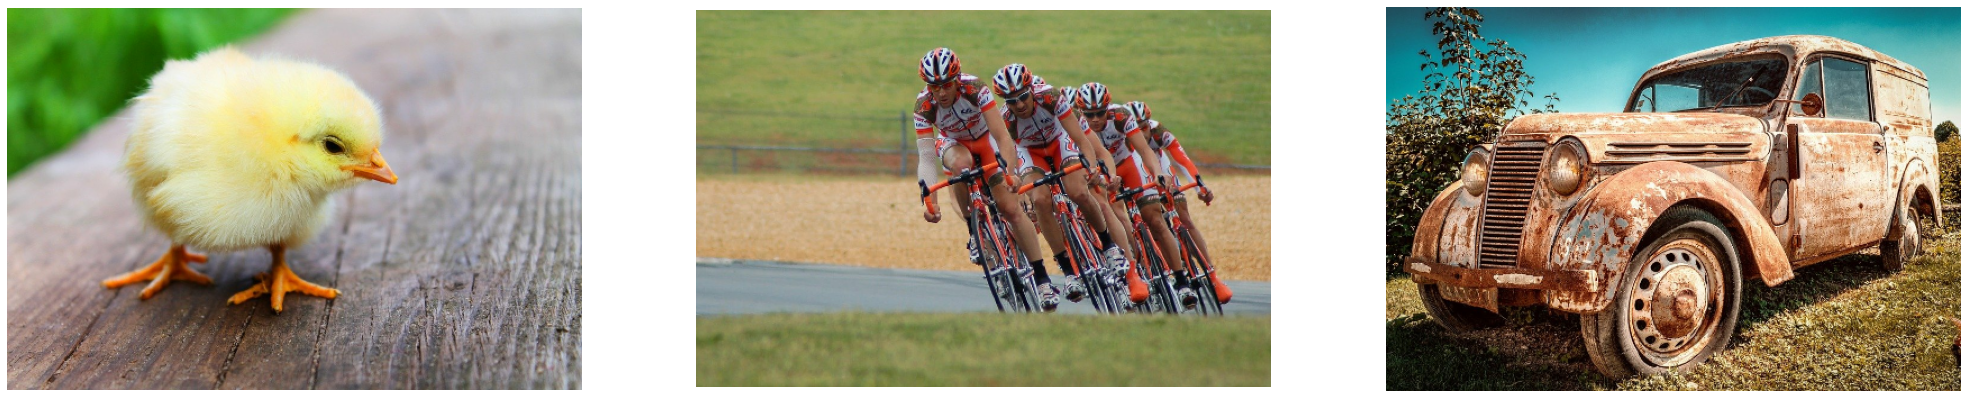

In [43]:
show_images(images, 1, 3, figsize=(35, 15))

We also download some images to use for styling:

In [22]:
%%bash
rm -rf styles
mkdir -p styles
curl -s -o styles/splashing.jpg https://cdn.pixabay.com/photo/2013/07/19/00/18/splashing-165192_960_720.jpg
curl -s -o styles/fireball.jpg https://cdn.pixabay.com/photo/2014/08/20/18/44/fireball-422746_960_720.jpg
curl -s -o styles/colorful.jpg https://cdn.pixabay.com/photo/2017/07/03/20/17/colorful-2468874_960_720.jpg
curl -s -o styles/texture.jpg https://cdn.pixabay.com/photo/2017/08/09/04/53/texture-2613518_960_720.jpg

In [23]:
styles = []
style_paths = glob.glob('styles/*')
for path in style_paths:
    styles.append(load_image(path))

Let's have quick look at the different styles

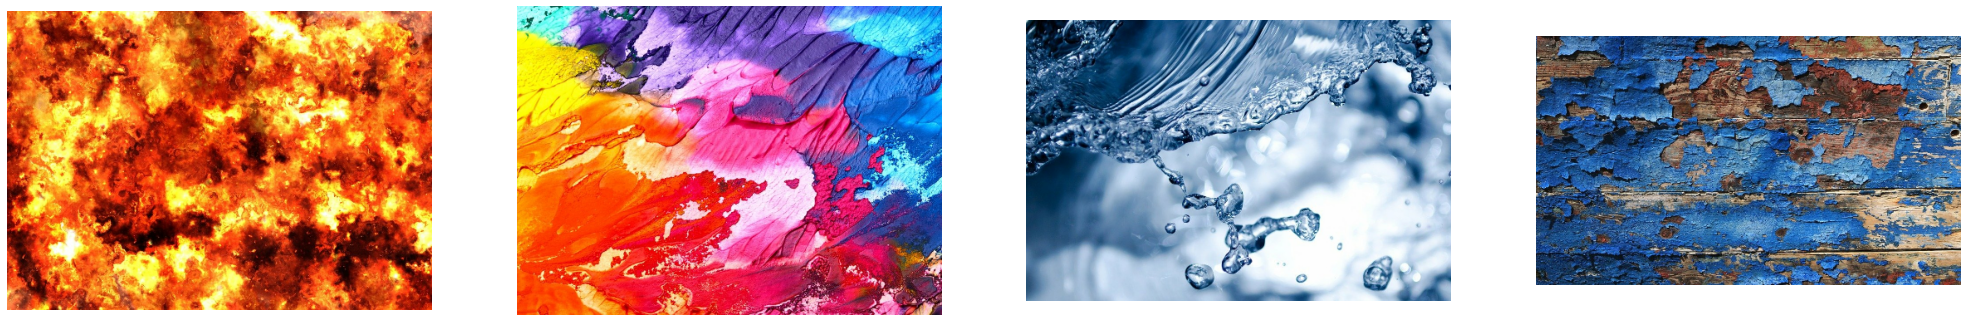

In [44]:
show_images(styles, 1, 4, figsize=(35, 15))

Finally, we iterate over each image/syle pair and pass them through the TF Hub module we loaded earlier:

In [34]:
stylized_images = []
for image in tqdm(images):
    image = image[tf.newaxis, :]
    for style in styles:
        style = style[tf.newaxis, :]
        results = hub_module(tf.constant(image), tf.constant(style))
        stylized_image = tensor_to_image(results[0])
        stylized_images.append(stylized_image)

100%|██████████| 3/3 [00:41<00:00, 13.90s/it]


Let's inspect the resulting images for each content image and syle

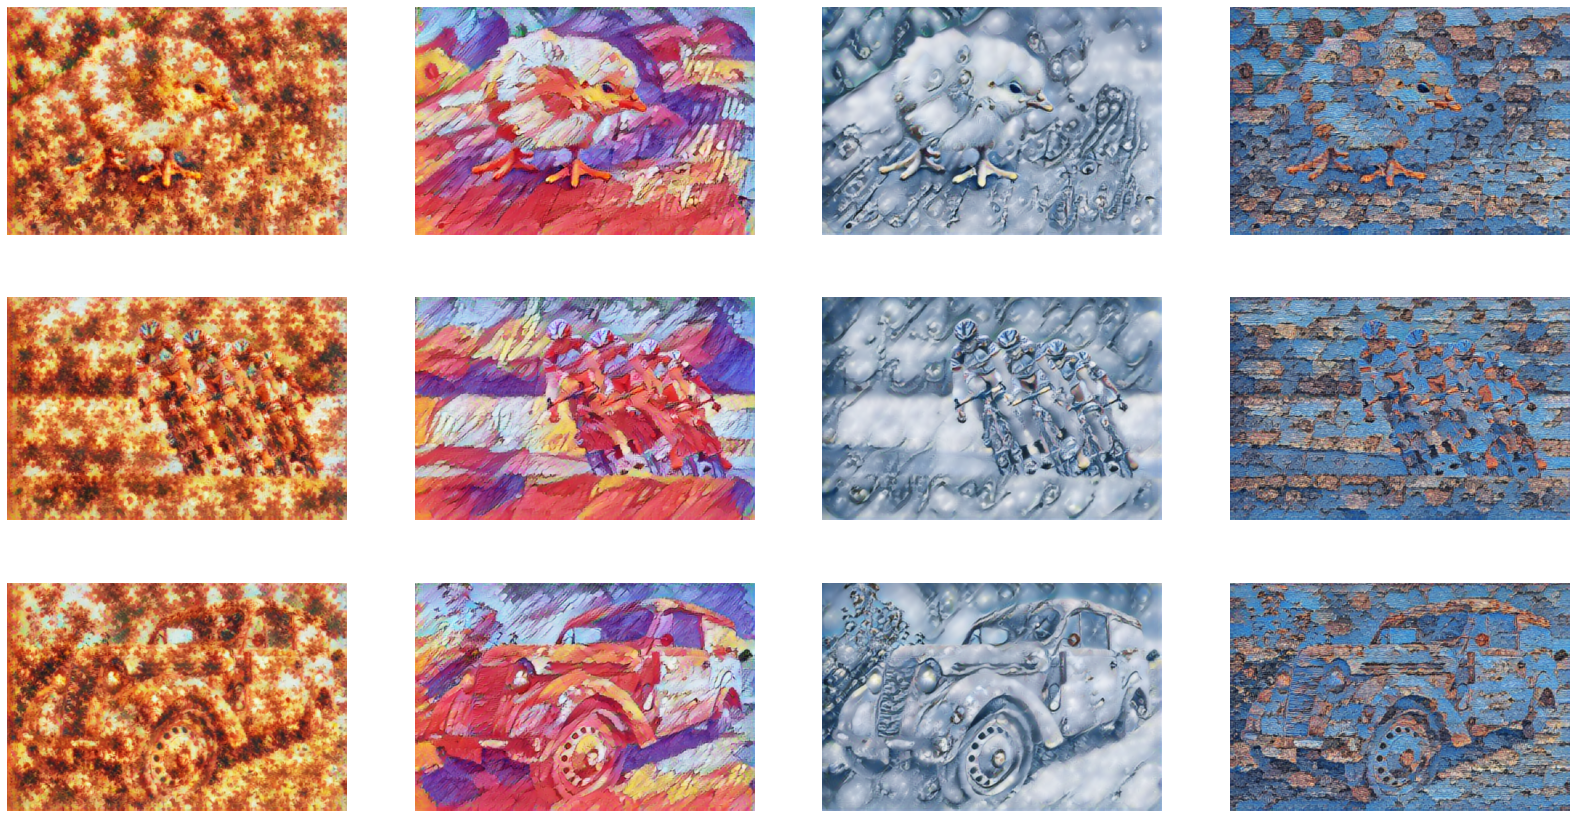

In [42]:
show_images(stylized_images, 3, 4, (28, 15))

The result looks pretty good as you can see, the resulting images preserve the coherence and meaning from the original scene, while adding artistic traits from the style images.